<a href="https://colab.research.google.com/github/FaridFK/pola-batik-baru/blob/main/batik_GAN_coba1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install Pillow==5.4.1
# !pip install torch==1.11.0
# !pip install torchvision==0.2.1
!pip install Pillow
!pip install torch
!pip install torchvision

import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import os, time

import itertools
import pickle
import imageio
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

# You can use whatever display function you want. This is a really simple one that makes decent visualizations
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
2.1.0+cu121


In [ ]:
# helper function to initialize the weights using a normal distribution.
# this was done in the original work (instead of xavier) and has been shown
# to help GAN performance
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [ ]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

In [ ]:
#####
# instantiate a Generator and Discriminator according to their class definition.
#####
G = Generator(128)
D = Discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G = G.cuda()
D = D.cuda()

print(D)
print(G)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)
Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, m

In [ ]:
samples = torch.randn(5, 3, 64,64).cuda() # batch size x channels x width x height
D(samples)

tensor([[[[0.3907]]],


        [[[0.4735]]],


        [[[0.1333]]],


        [[[0.4796]]],


        [[[0.1719]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
for name, p in D.named_parameters():
    print(name, p.shape)

conv1.weight torch.Size([128, 3, 4, 4])
conv1.bias torch.Size([128])
conv2.weight torch.Size([256, 128, 4, 4])
conv2.bias torch.Size([256])
conv2_bn.weight torch.Size([256])
conv2_bn.bias torch.Size([256])
conv3.weight torch.Size([512, 256, 4, 4])
conv3.bias torch.Size([512])
conv3_bn.weight torch.Size([512])
conv3_bn.bias torch.Size([512])
conv4.weight torch.Size([1024, 512, 4, 4])
conv4.bias torch.Size([1024])
conv4_bn.weight torch.Size([1024])
conv4_bn.bias torch.Size([1024])
conv5.weight torch.Size([1, 1024, 4, 4])
conv5.bias torch.Size([1])


In [ ]:
for name, p in G.named_parameters():
    print(name, p.shape)

deconv1.weight torch.Size([100, 1024, 4, 4])
deconv1.bias torch.Size([1024])
deconv1_bn.weight torch.Size([1024])
deconv1_bn.bias torch.Size([1024])
deconv2.weight torch.Size([1024, 512, 4, 4])
deconv2.bias torch.Size([512])
deconv2_bn.weight torch.Size([512])
deconv2_bn.bias torch.Size([512])
deconv3.weight torch.Size([512, 256, 4, 4])
deconv3.bias torch.Size([256])
deconv3_bn.weight torch.Size([256])
deconv3_bn.bias torch.Size([256])
deconv4.weight torch.Size([256, 128, 4, 4])
deconv4.bias torch.Size([128])
deconv4_bn.weight torch.Size([128])
deconv4_bn.bias torch.Size([128])
deconv5.weight torch.Size([128, 3, 4, 4])
deconv5.bias torch.Size([3])


In [ ]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 100).view(-1,100,1,1).cuda()
x_gen = G(z)
#notice that the generated value is a batch of 2 images
x_gen.shape

torch.Size([2, 3, 64, 64])

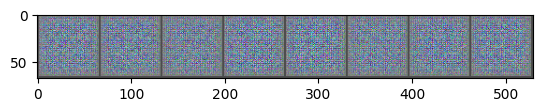

In [ ]:
z = torch.randn(8, 100).view(-1,100,1,1).cuda()
G = G.cuda()
show_imgs(G(z))

In [ ]:
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), requires_grad=False)

In [ ]:
G = Generator(128)
D = Discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G = G.cuda()
D = D.cuda()

In [ ]:
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), requires_grad=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/'My Drive'/batik_coba.zip
!mkdir batik_coba
!mv vz7pzt2grf-1 batik_coba

Mounted at /content/drive
Archive:  drive/My Drive/batik_coba.zip
  inflating: vz7pzt2grf-1/B2_1.jpg   
  inflating: vz7pzt2grf-1/B2_4.jpg   
  inflating: vz7pzt2grf-1/B1_4.jpg   
  inflating: vz7pzt2grf-1/B1_3.jpg   
  inflating: vz7pzt2grf-1/B2_2.jpg   
  inflating: vz7pzt2grf-1/B1_1.jpg   
  inflating: vz7pzt2grf-1/B1_5.jpg   
  inflating: vz7pzt2grf-1/B1_6.jpg   
  inflating: vz7pzt2grf-1/B2_3.jpg   
  inflating: vz7pzt2grf-1/B1_2.jpg   
  inflating: vz7pzt2grf-1/B2_6.jpg   
  inflating: vz7pzt2grf-1/B2_5.jpg   
  inflating: vz7pzt2grf-1/B3_1.jpg   
  inflating: vz7pzt2grf-1/B3_2.jpg   
  inflating: vz7pzt2grf-1/B3_3.jpg   
  inflating: vz7pzt2grf-1/B3_4.jpg   
  inflating: vz7pzt2grf-1/B4_1.jpg   
  inflating: vz7pzt2grf-1/B3_6.jpg   
  inflating: vz7pzt2grf-1/B3_5.jpg   
  inflating: vz7pzt2grf-1/B4_2.jpg   
  inflating: vz7pzt2grf-1/B4_3.jpg   
  inflating: vz7pzt2grf-1/B4_4.jpg   
  inflating: vz7pzt2grf-1/B4_6.jpg   
  inflating: vz7pzt2grf-1/B4_5.jpg   
  inflating: vz7pzt2gr

In [ ]:
!ls ./batik_coba

vz7pzt2grf-1


In [ ]:
batch_size = 32
lr = 0.0002
train_epoch = 100
img_size = 64

#download the data, and change the filepath
dataset = datasets.ImageFolder(root='./batik_coba',
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
##### Create the dataloader #####
train_loader = DataLoader(dataset,
                  batch_size=batch_size,
                  shuffle=True,
                  num_workers=2,
                  pin_memory=True)

In [ ]:
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

[1/100] - ptime: 1.75, loss_d: 15.189, loss_g: 11.682
[21/100] - ptime: 1.76, loss_d: 0.000, loss_g: 51.031
[41/100] - ptime: 1.90, loss_d: 0.000, loss_g: 50.892
[61/100] - ptime: 1.76, loss_d: 0.000, loss_g: 50.654
[81/100] - ptime: 1.78, loss_d: 0.000, loss_g: 50.576


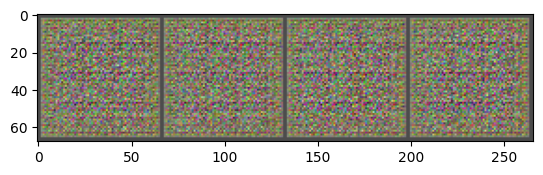

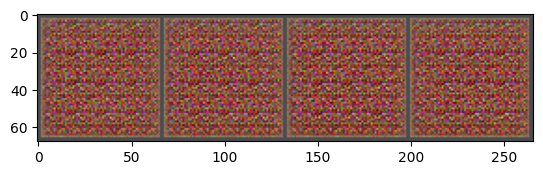

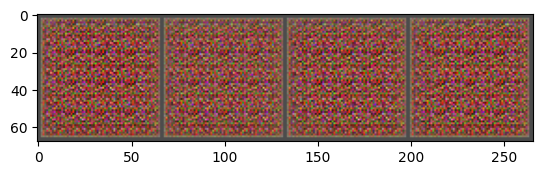

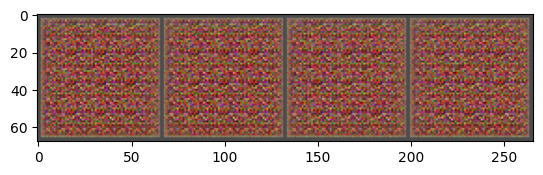

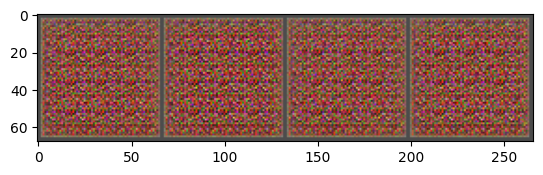

In [ ]:
import torch
import torch.nn.functional as F

# Definisi fungsi loss
BCE_loss = torch.nn.BCELoss()

num_iter = 0
collect_x_gen = []
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in train_loader:
        mini_batch = x_.size()[0]

        # train discriminator D
        D.zero_grad()

        #####
        # create y_real_ and y_fake_ tensors you will use in your BCE loss to push probabilities
        # in the proper direction
        # y_real_ will be a tensor of all ones, because you want whatever is output by the generator
        # to be more likely to be real and you want the discriminator to recognize real images
        # y_fake_ then is a tensor of all zeros, because you want the discriminator to recognize fake images
        #####

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())

        #####
        # pass x_ through the decoder to get D_result
        # you will need to squeeze() the output before passing it to BCE_loss
        # compute D_real_loss using BCE_loss and the proper y tensor from above
        # you are trying to make the discriminator recognize the real image properly
        #####

        D_result = D(x_)

        # do some size matching/unsqueezing
        D_result = torch.squeeze(D_result)
        D_real_loss = BCE_loss(D_result, y_real_)

        #####
        # sample a z vector (remember to view(-1,100,1,1))
        # pass the z vector to the GPU and through your generator
        # this will create G_result
        #####
        z_ = torch.randn(mini_batch, 100).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)

        #####
        # pass G_result through the discriminator and get D_result
        # you will need to squeeze() the output of the discriminator
        # compute D_fake_loss for the generated images by using BCE_loss and the proper y_tensor
        # you are trying to make the discriminator recognize the fake image properly
        # reduce D_fake_loss to the mean value
        #####

        D_result = D(G_result)
        D_result = torch.squeeze(D_result)

        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_loss_mean = torch.mean(D_fake_loss)

        #####
        # sum D_real_loss and D_fake_loss to get D_train_loss
        # compute the gradients
        # step the optimizer
        #####

        D_train_loss = D_real_loss + D_fake_loss_mean
        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        #####
        # sample a z vector (viewed properly) and pass it to the GPU and through the generator
        # compute the discriminated value of the generated image, properly squeezing the output
        # get G_train_loss by using BCE_loss and the proper y_tensor
        # you are trying to make the generator generate real images
        # compute the gradients
        # step the optimizer
        #####

        z_ = torch.randn(mini_batch, 100).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)

        Scores = D(G_result)
        Scores = torch.squeeze(Scores)

        G_train_loss = BCE_loss(Scores, y_real_)

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

        num_iter += 1

    # generate a fixed_z_ image and save
    if epoch % 20 == 0:
      x_gen = G(fixed_z_)
      collect_x_gen.append(x_gen.detach().clone())
      epoch_end_time = time.time()
      per_epoch_ptime = epoch_end_time - epoch_start_time

      # print out statistics
      print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
      show_imgs(G_result[:4])

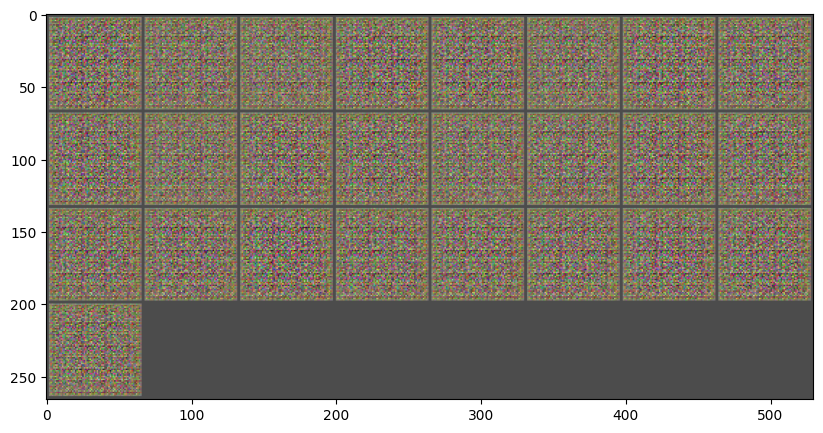

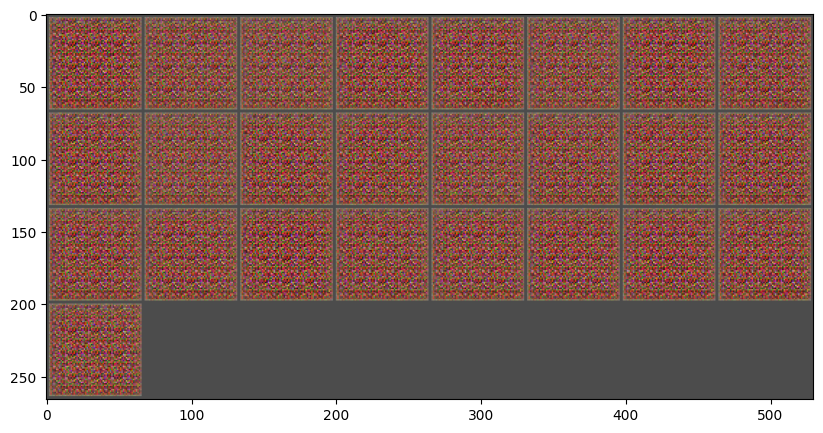

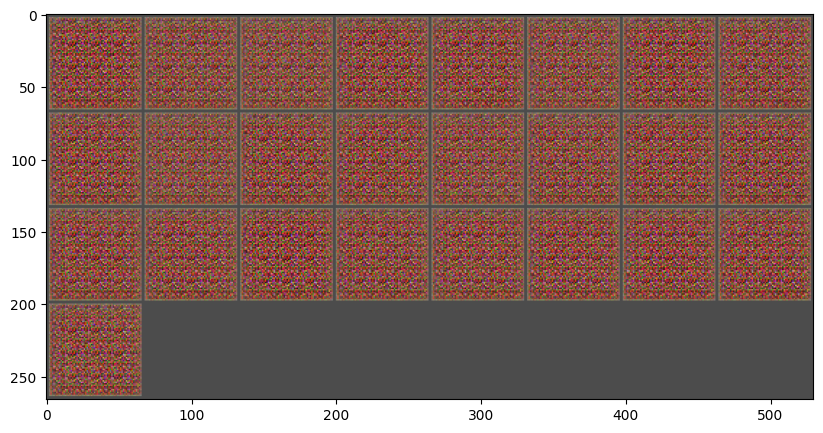

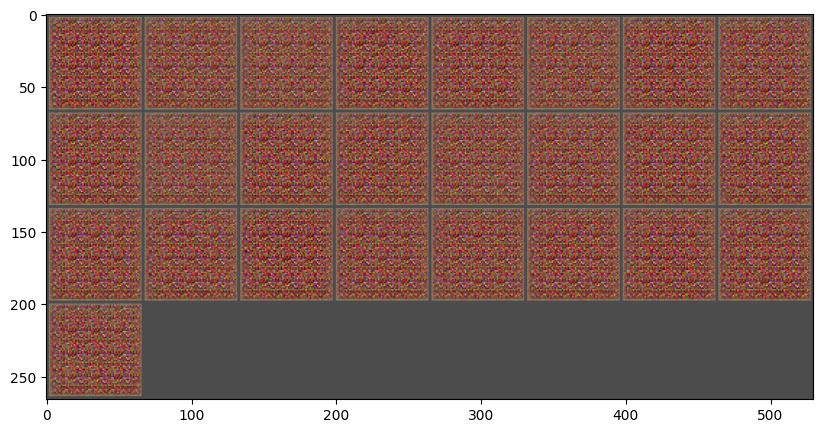

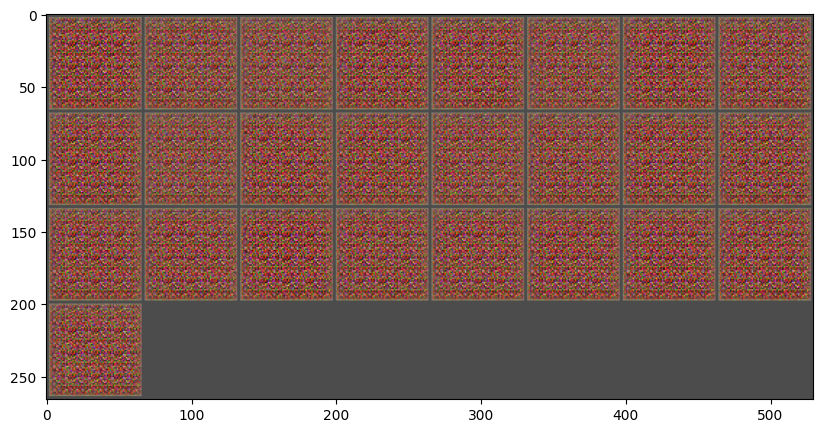

In [ ]:
plt.rcParams['figure.figsize'] = [15,5]
for x_gen in collect_x_gen:
    show_imgs(x_gen)
plt.rcParams['figure.figsize'] = [8,6]